In [394]:
import cplex
import numpy
import re
from datetime import datetime, timedelta

cpx = cplex.Cplex()

n = 4
N = [str(i) for i in range(1, n+1)]
N_hat = ['h' + item for item in N]

is_cloned = {original: cloned  for original, cloned in zip(N, N_hat)}

V = N + N_hat

V_0 = V.copy()
V_0.append(str(0))

V_1 = V.copy()
V_1.append(str(len(N) + 1))

V_2 = V.copy()
V_2.append(str(0))
V_2.append(str(len(N) + 1))

A_1 = {(i, j) for i in V for j in V if i != j and (j not in is_cloned or is_cloned[j] != j)}
A_2 = {(original, cloned) for original, cloned in is_cloned.items()}
A_3 = {(str(0), j) for j in V}
A_4 = {(i, str(len(N) + 1)) for i in V}
A_5 = {(cloned, original) for original, cloned in is_cloned.items()}

A = A_1.union(A_2, A_3, A_4) - A_5
A_p = A - A_2

def time_to_m(time_str):
    hour, minute = map(int, time_str.split(':'))
    return hour * 60 + minute

T = [1,2]
B = ['1','2','3','4']
CB_l = [75,75,75,75]

S_i = [0] * len(V)
C_i = [40] * len(N)
CT = 2

T_ij = {}
for (i, j) in A:
    if (i, j) in A_2:
        T_ij[(i, j)] = C_i[V.index(i)] 
    else:
        T_ij[(i, j)] = 10

E_i = ['01:00','01:20','01:10','01:20']
E_i = [time_to_m(E_i[i]) for i in range(len(E_i))]
L_i = ['02:00','02:20','02:10','02:20']
L_i = [time_to_m(L_i[i]) for i in range(len(L_i))]
R_i = [30,30,30,30]
Depo_time = ['00:00', '06:00']
E_0 = [time_to_m(Depo_time[0])]
L_n = [time_to_m(Depo_time[1])]

M = 10000
alp = 1000
lamb = 10000

In [395]:
cpx.objective.set_sense(cpx.objective.sense.maximize)

x_i_j = lambda i, j: 'x_%s_%s' % (i, j)
y_i_j_l = lambda i, j, l: 'y_%s_%s_%s' % (i, j, l)
z_i_l = lambda i, l: 'z_%s_%s' % (i, l)
o_i = lambda i: 'o_%s' % (i)
u_i = lambda i: 'u_%s' % (i)
v_i = lambda i: 'v_%s' % (i)

cpx.variables.add(
    obj=[-1 for (i, j) in A],
    ub=[1 for (i, j) in A],
    lb=[0 for (i, j) in A],
    types=['B' for (i, j) in A],
    names=[x_i_j(str(i), str(j)) for (i, j) in A]
)
cpx.variables.add(
    obj=[0 for (i, j) in A for l in B],
    ub=[1 for (i, j) in A for l in B],
    lb=[0 for (i, j) in A for l in B],
    types=['B' for (i, j) in A for l in B],
    names=[y_i_j_l(str(i), str(j), str(l)) for (i, j) in A for l in B]
)

cpx.variables.add(
    obj=[0 for i in N for l in B],
    ub=[1 for i in N for l in B],
    lb=[0 for i in N for l in B],
    types=['B' for i in N for l in B],
    names=[z_i_l(str(i), str(l)) for i in N for l in B]
)

cpx.variables.add(
    obj=[100 for i in N],
    ub=[1 for i in N],
    lb=[0 for i in N],
    types=['B' for i in N],
    names=[o_i(str(i)) for i in N]
)

cpx.variables.add(
    obj=[0 for i in V_1],
    lb=[0 for i in V_1],
    types=['C' for i in V_1],
    names=[u_i(str(i)) for i in V_1]
)

cpx.variables.add(
    obj=[0 for i in V_0],
    lb=[0 for i in V_0],
    types=['C' for i in V_0],
    names=[v_i(str(i)) for i in V_0]
)

range(369, 378)

In [396]:
#2
T_len = len(T)

cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[x_i_j(0, i) for i in V],
            val=[1 for i in V]
        )
    ],
    senses=['L'],
    rhs=[T_len],
    names=['const2']
)


range(0, 1)

In [397]:
#3
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[x_i_j(a, b) for (a,b) in A if b == j ],
            val=[1 for (a,b) in A if b == j  ]
        ) for j in V
    ],
    senses=['L' for j in V],
    rhs=[1 for j in V],
    names=['const3_%s' % j for j in V]
)

range(1, 9)

In [398]:
#4
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[x_i_j(a, b) for (a, b) in A if a == i] + [x_i_j(c, d) for (c,d) in A if d == i],
            val=[1 for (a, b) in A if a == i] + [-1 for (c, d) in A if d == i]
        ) for i in V
    ],
    
    senses=['E' for i in V] ,
    rhs=[0 for i in V],
    names=['const4_%s' % (i) for i in V]
)


range(9, 17)

In [399]:
#5
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[x_i_j(a, b) for (a, b) in A if b == i ] + [x_i_j(c, d) for (c, d) in A if d == j],
            val=[1 for (a, b) in A if b == i] + [-1 for (c, d) in A if d == j]
        ) for (i,j) in A_2
    ], 
    senses=['E' for (i,j) in A_2],
    rhs=[0 for (i,j) in A_2],
    names=['const5_%s_%s' % (i, j) for (i,j) in A_2]
) 


range(17, 21)

In [400]:
#6
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[y_i_j_l(0, i, l) for i in V],
            val=[1 for i in V]
        ) for l in B
    ],
    senses=['L' for l in B],
    rhs=[1 for l in B],
    names=['const6_%s' % (l) for l in B]
)


range(21, 25)

In [401]:
#7
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[y_i_j_l(a, b, l) for (a, b) in A if a == i] + [y_i_j_l(c, d, l) for (c, d) in A if d == i],
            val=[1] * len([y_i_j_l(a, b, l) for (a, b) in A if a == i]) + [-1] * len([y_i_j_l(c, d, l) for (c, d) in A if d == i])
        ) for i in V for l in B
    ],
    senses=['E' for i in V for l in B] ,
    rhs=[0 for i in V for l in B] ,
    names=['const7_%s_%s' % (i, l) for i in V for l in B]
)


range(25, 57)

In [402]:
#8
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[x_i_j(i, j)] + [y_i_j_l(i, j, l) for l in B],
            val=[CT] + [-1 for l in B]
        ) for (i,j) in A_p
    ],
    senses=['G' for (i,j) in A_p],
    rhs=[0 for (i,j) in A_p],
    names=['const8_%s_%s' % (i,j) for (i,j) in A_p]
)


range(57, 121)

In [403]:
#9
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[z_i_l(i, l) for i in N],
            val=[R_i[N.index(i)] for i in N]
        ) for l in B
    ],
    senses=['L' for l in B],
    rhs=[CB_l[B.index(l)] for l in B],
    names=['const9_%s' % (l) for l in B]
)

range(121, 125)

In [404]:
#10
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[z_i_l(i,l) for l in B],
            val=[1 for l in B]
        ) for i in N
    ],
    senses=['L' for i in N],
    rhs=[1 for i in N],
    names=['const10_%s' % (i) for i in N]
)

range(125, 129)

In [405]:
#11
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[o_i(i)] + [z_i_l(i, l) for l in B],
            val=[1] + [-1 for l in B]
        ) for i in N
    ],
    senses=['E' for i in N],
    rhs=[0 for i in N],
    names=['const11_%s' % (i) for i in N]
)

range(129, 133)

In [406]:
#12
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[y_i_j_l(i, j, l)] + [z_i_l(i, l)],
            val=[1] + [-1]
        ) for (i, j) in A_2 for l in B
    ],
    senses=['E' for (i, j) in A_2 for l in B],
    rhs=[0 for (i, j) in A_2 for l in B],
    names=['const12_%s_%s_%s' % (i, j, l) for (i, j) in A_2 for l in B]
)

range(133, 149)

In [407]:
#13
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[v_i(i)] + [u_i(i)],
            val=[1] + [-1]
        ) for i in V
    ],
    senses=['G' for i in V],
    rhs=[S_i[i] for i in range(0,len(V))],
    names=['const13_%s' % (i) for i in V]
)

range(149, 157)

In [408]:
#14
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[v_i(i)] + [u_i(j)] + [x_i_j(i,j)],
            val=[1] + [-1] + [M]
        ) for (i,j) in A
    ],
    senses=['L' for (i,j) in A],
    rhs=[ - T_ij[(i,j)] + M for (i,j) in A],
    names=['const14_%s_%s' % (i,j) for (i,j) in A]
)


range(157, 225)

In [409]:
#15
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[u_i(j)] + [v_i(i)],
            val=[1] + [-1]
        ) for (i, j) in A_2
    ],
    senses=['G' for (i, j) in A_2],
    rhs=[C_i[N.index(i)] for (i, j) in A_2],
    names=['const15_%s_%s' % (i,j) for (i, j) in A_2]
)

range(225, 229)

In [410]:
#16 떠나는 i_hat lower bound 
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[v_i(j)],
            val=[1]
        ) for (i, j) in A_2
    ],
    senses=['G' for (i, j) in A_2],
    rhs=[E_i[N.index(i)] + S_i[N.index(i)] + C_i[N.index(i)] + S_i[N_hat.index(j)] for (i, j) in A_2],
    names=['const16_%s_%s' % (i,j) for (i, j) in A_2]
)

range(229, 233)

In [411]:
#17 들어오는 i upper bound 최소 이전에는 들어와야함
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[u_i(i)],
            val=[1]
        ) for (i, j) in A_2
    ],
    senses=['L' for (i, j) in A_2],
    rhs=[ L_i[N.index(i)]- S_i[N.index(i)] -C_i[N.index(i)] -S_i[N_hat.index(j)] for (i, j) in A_2],
    names=['const17_%s_%s' % (i,j) for (i, j) in A_2]
)

range(233, 237)

In [412]:
#17-2 떠나는 i lower bound 
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[v_i(i)],
            val=[1]
        ) for i in N
    ],
    senses=['G' for i in N],
    rhs=[E_i[N.index(i)] + S_i[N.index(i)] for i in N],
    names=['const17-2_%s' % (i) for i in N]
)

range(237, 241)

In [413]:
#18
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[v_i(str(0))],
            val=[1]
        )
    ],
    senses=['G'],
    rhs=[E_0[0]],
    names=['const18']
)

range(241, 242)

In [414]:
#19
cpx.linear_constraints.add(
    lin_expr=[
        cplex.SparsePair(
            ind=[u_i(str(len(N)+1))],
            val=[1]
        )
    ],
    senses=['L'],
    rhs=[L_n[0]],
    names=['const19']
)

range(242, 243)

In [415]:
cpx.solve()

print("Objective Value:", cpx.solution.get_objective_value()) 

print("Variable Values:")
variable_names = cpx.variables.get_names()
variable_values = cpx.solution.get_values()

for name, value in zip(variable_names, variable_values):
    if value >= 0.0001:

        print(name, "=", value) 

print("Solution status:", cpx.solution.get_status())

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.05 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 64 rows and 72 columns.
MIP Presolve modified 124 coefficients.
Aggregator did 20 substitutions.
Reduced MIP has 159 rows, 286 columns, and 990 nonzeros.
Reduced MIP has 274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.08 ticks)
Probing time = 0.00 sec. (0.96 ticks)
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve modified 24 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 155 rows, 282 columns, and 982 nonzeros.
Reduced MIP has 274 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.95 ticks)
Probing time = 0.00 sec. (0.95 ticks)
Clique table members: 790.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 thre

In [416]:
cpx.write('eve_01.lp')

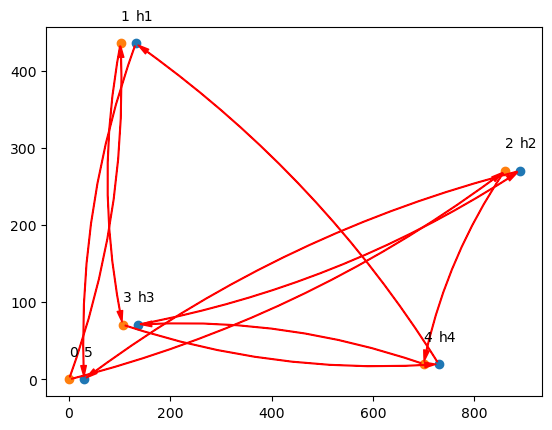

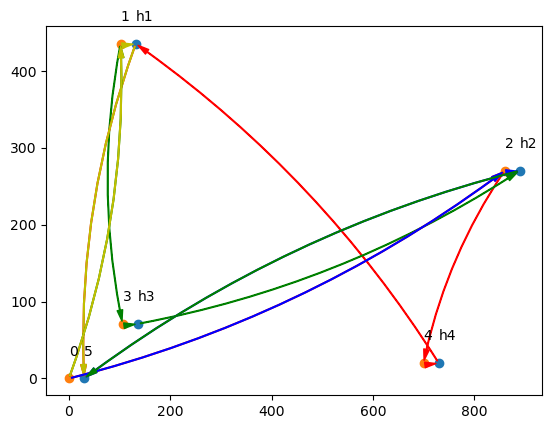

In [446]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ans = {}
for name, value in zip(variable_names, variable_values):
    ans[name] = value

ans_starting_with_x = {key: value for key, value in ans.items() if key.startswith('x')}
ax_list = []
for key, value in zip(ans_starting_with_x.keys(), ans_starting_with_x.values()):
    key_split = key.split("_")
    ax_list.append((key_split,value))
interval = 30
point = {}
point_h = {}
interval = 30
point['0'] = (0, 0) 
point_h[f'{n+1}'] = (interval, 0) 
np.random.seed(42) 
for i in range(1, n+1):  
    x = np.random.randint(0,1000)
    y = np.random.randint(0,1000)
    point[f'{i}'] = (x, y)  
    point_h[f'h{i}'] = (x + interval, y)  

x_h_values = [value[0] for value in point_h.values()]
y_h_values = [value[1] for value in point_h.values()]
plt.scatter(x_h_values, y_h_values)

x_values = [value[0] for value in point.values()]
y_values = [value[1] for value in point.values()]
plt.scatter(x_values, y_values)

for i in point_h:
    plt.text(point_h[i][0],point_h[i][1]+interval, i)
for i in point:
    plt.text(point[i][0],point[i][1]+interval, i)


for i in range(len(ax_list)-1):
    if ax_list[i][1] > 0:
        if ax_list[i][0][1].startswith('h') or ax_list[i][0][1].startswith(f'{n+1}') :
            start = point_h[ax_list[i][0][1]]
        else:
            start = point[ax_list[i][0][1]]
        
        if ax_list[i][0][2].startswith('h') or ax_list[i][0][2].startswith(f'{n+1}') :
            end = point_h[ax_list[i][0][2]]
        else:
            end = point[ax_list[i][0][2]]
        line_1 = patches.FancyArrowPatch((start[0], start[1]), (end[0], end[1]), connectionstyle="arc3,rad=0.1", arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color='r')
        plt.gca().add_patch(line_1)
        #plt.arrow(start[0],  start[1], end[0] - start[0]  , end[1] - start[1] , head_width=10, head_length=10, fc='black', ec='red')
    else:
        pass
     
plt.show()


ans = {}
for name, value in zip(variable_names, variable_values):
    ans[name] = value

ans_starting_with_y = {key: value for key, value in ans.items() if key.startswith('y')}

ay_list = []
for key, value in zip(ans_starting_with_y.keys(), ans_starting_with_y.values()):
    key_split = key.split("_")
    ay_list.append((key_split,value))

x_h_values = [value[0] for value in point_h.values()]
y_h_values = [value[1] for value in point_h.values()]
plt.scatter(x_h_values, y_h_values)

x_values = [value[0] for value in point.values()]
y_values = [value[1] for value in point.values()]
plt.scatter(x_values, y_values)


for i in point_h:
    plt.text(point_h[i][0],point_h[i][1]+interval, i)
for i in point:
    plt.text(point[i][0],point[i][1]+interval, i)

for i in range(len(ay_list)-1):
    
    if ay_list[i][1] > 0:
        if ay_list[i][0][1].startswith('h') or ay_list[i][0][1].startswith(f'{n+1}') :
            start = point_h[ay_list[i][0][1]]
        else:
            start = point[ay_list[i][0][1]]
        
        if ay_list[i][0][2].startswith('h') or ay_list[i][0][2].startswith(f'{n+1}') :
            end = point_h[ay_list[i][0][2]]
        else:
            end = point[ay_list[i][0][2]]
        if ay_list[i][0][3] == '1':
            a_1 = patches.FancyArrowPatch((start[0], start[1]), (end[0], end[1]), connectionstyle="arc3,rad=0.1", arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color='r')
            plt.gca().add_patch(a_1)
        if ay_list[i][0][3] == '2':
            a_2 = patches.FancyArrowPatch((start[0], start[1]), (end[0], end[1]), connectionstyle="arc3,rad=0.1", arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color='b')                
            plt.gca().add_patch(a_2)
        if ay_list[i][0][3] == '3':
            a_3 = patches.FancyArrowPatch((start[0], start[1]), (end[0], end[1]), connectionstyle="arc3,rad=0.1", arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color='g')                
            plt.gca().add_patch(a_3)
        if ay_list[i][0][3] == '4':
            a_4 = patches.FancyArrowPatch((start[0], start[1]), (end[0], end[1]), connectionstyle="arc3,rad=0.1", arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color='y')                
            plt.gca().add_patch(a_4)
    else:
        pass
     
plt.show()